# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# 2. Remove dodgy images

In [106]:
import cv2
import imghdr

In [107]:
data_dir = 'data' 

In [108]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [190]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list data\crack\54774088.jpg
Image not in ext list data\crack\Blog-Image-2311-Reducing-Concrete-Cracking.jpg
Image not in ext list data\crack\BowedWallCrack1.jpg
Image not in ext list data\crack\cracked-concrete-wall-hd-goa5dtd78agxo91m.jpg
Image not in ext list data\crack\Cracks-in-walls.jpg
Image not in ext list data\crack\ct-background-or-clipping-mask-texture-surface-fracture-structure-2157605251.jpg
Image not in ext list data\crack\depositphotos_169236572-stock-photo-an-old-real-wall-texture.jpg
Image not in ext list data\crack\e-for-background-cement-floor-texture-concrete-floor-texture-were-2298114445.jpg
Image not in ext list data\crack\Foundation-heave-crack.webp
Image not in ext list data\crack\foundationcrackrepair_Ramjack.jpg
Image not in ext list data\crack\foundationrepairOKC_Ramjack.jpg
Image not in ext list data\crack\on-white-wall-there-large-260nw-1564590907.jpg
Image not in ext list data\crack\stration-of-realistic-wall-cracks-set-isolated-on-transpa

# 3. Load Data

In [191]:
import numpy as np
from matplotlib import pyplot as plt

In [192]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 288 files belonging to 1 classes.


In [193]:
data_iterator = data.as_numpy_iterator()

In [194]:
batch = data_iterator.next()

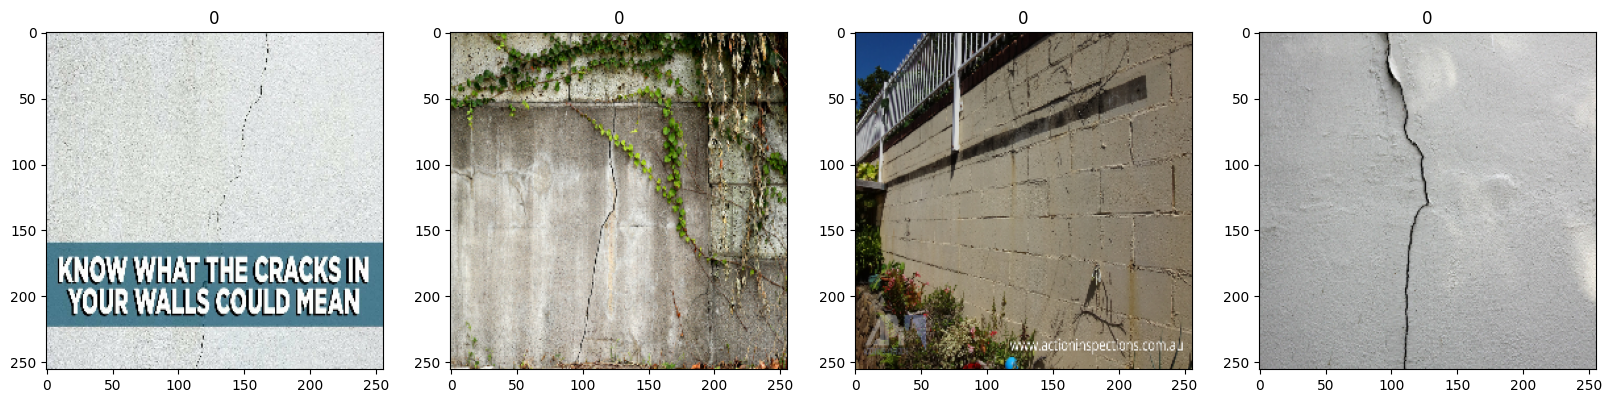

In [195]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [196]:
data = data.map(lambda x,y: (x/255, y))

In [197]:
data.as_numpy_iterator().next()

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[1.        , 1.        , 0.99215686],
          [1.     

# 5. Split Data

In [198]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [199]:
train_size

6

In [200]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [201]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [202]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [203]:
model = Sequential()

In [204]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [205]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [206]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 16)      

# 7. Train

In [207]:
logdir='logs'

In [208]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [209]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
6/6 [==============================] - 4s 416ms/step - loss: 0.1149 - accuracy: 0.9271 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/20
6/6 [==============================] - 4s 362ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
6/6 [==============================] - 3s 351ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
6/6 [==============================] - 4s 381ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/20
6/6 [==============================] - 3s 376ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
6/6 [==============================] - 4s 376ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
6/6 [==============================] - 4s 418ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.

# 8. Plot Performance

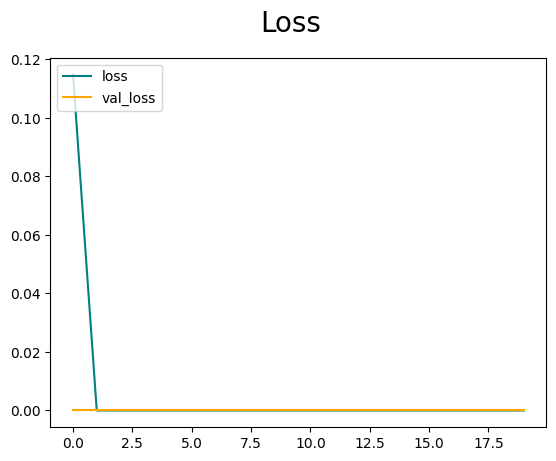

In [210]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

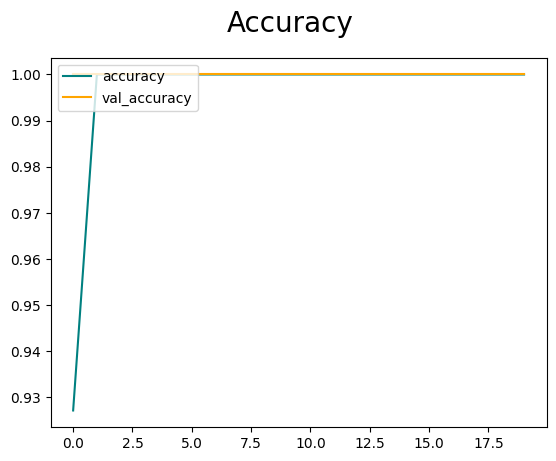

In [211]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [212]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [213]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [214]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [215]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# 10. Test

In [216]:
import cv2
import numpy

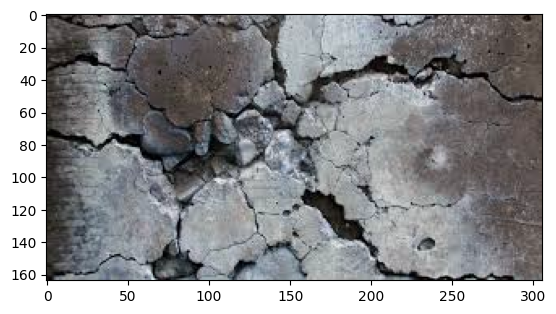

In [217]:
img = cv2.imread('images.jpg')
plt.imshow(img)
plt.show()

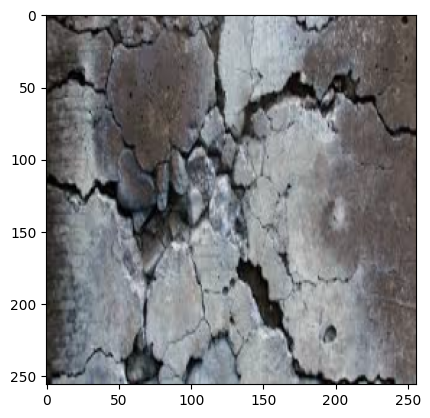

In [218]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [219]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 59ms/step


In [220]:
yhat

array([[0.]], dtype=float32)

In [221]:
if yhat == 0: 
    print(f'Predicted class is crack')
else:
    print(f'Predicted class is not-crack')

Predicted class is crack


# 11. Save the Model

In [222]:
from tensorflow.keras.models import load_model

In [225]:
model.save(os.path.join('models','crackclassifier.h5'))

In [227]:
new_model = load_model('models/crackclassifier.h5')

In [228]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 48ms/step


array([[0.]], dtype=float32)